## 近傍銀河「M100 CO分子輝線データ」

ここで使用するデータは、ALMA Band 3で観測された近傍銀河「M100」のCO <i>J</i>=1-0分子輝線キューブイメージデータです。
<br>
<a href="https://almascience.nao.ac.jp/alma-data/science-verification" target="_blank" rel="noopener">Science Verification Data</a>の一つとして取得されたデータで（「4. M100 Band 3」を参照）、12mアレイ, 7mアレイ, TP(単一鏡)データを結合するデモンストレーションとして作成されたイメージを使用します。
また、初期解析及びイメージングについてはCASAガイドが参考になります（CASA Guide : <a href="https://casaguides.nrao.edu/index.php/M100_Band3" target="_blank" rel="noopener">M100 Band3</a>）。

JVOのサイトからもイメージFITSを直接ダウンロードできます。<br>
- Dataset Information :
    https://jvo.nao.ac.jp/portal/alma/sv.do?action=dataset.info&datasetId=ALMA00000188 <br>
- FITS link:
    http://jvo.nao.ac.jp/skynode/do/download/alma/public/cube_primary/ALMA00000188_00_00_00

### モジュールの読み込み（インストール）

最初に、Google Colab環境の場合、CASAモジュールをインストールしてCASA実行環境を構築する処理を行っています。

In [1]:
import sys, os
print(sys.version)

3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


In [2]:
# For Google Colaboratory（Google Colab環境か判別し、Google Colab環境ならCASA実行環境を構築）
print(type(sys.modules))
moduleList = sys.modules
ENV_COLAB = False

if 'google.colab' in moduleList:
    print("google_colab")
    ENV_COLAB = True
else:
    print("Not google_colab")

if ENV_COLAB:
    print("Execute in google_colab")
#    print("installing pre-requisite packages...\n")

    print("installing casa packages...\n")
    !pip install casatools==6.6.0.20 # should install version 6.6.0 or later for Google Colab (python 3.10)
    !pip install casatasks==6.6.0.20
#    !pip install casatools
#    !pip install casatasks
    !pip install casadata

    print("make a config file for Google Colab...\n")
    !mkdir ~/.casa
    !echo "home     = '/content/'" > ~/.casa/config.py
    !echo "datapath = ['`find / -type d -name casadata`']" >> ~/.casa/config.py
    !more ~/.casa/config.py
    print("Completion of CASA preparation")

<class 'dict'>
google_colab
Execute in google_colab
installing casa packages...

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.8/188.8 MB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 MB 2.7 MB/s eta 0:00:00
make a config file for Google Colab...

find: ‘/proc/57/task/57/net’: Invalid argument
find: ‘/proc/57/net’: Invalid argument
home     = '/content/'
datapath = ['/usr/local/lib/python3.10/dist-packages/casadata']
Completion of CASA preparation


In [3]:
import casatools
import casatasks

以下では必要なモジュールを読み込んでいます。<br>
ローカル環境で実行する場合は、以下で読み込んでいるモジュール及びCASAモジュールをあらかじめインストールしてから実行して下さい。

In [4]:
#import sys, os
import math
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from matplotlib import pyplot as plt

### JVOよりイメージFITSデータのダウンロード

In [5]:
url = 'http://jvo.nao.ac.jp/skynode/do/download/alma/public/cube_primary/ALMA00000188_00_00_00'
orgimfits='ALMA00000188_00_00_00.fits'
orgimgdat='M100_combine_CO_cube.image'
myimages ='M100_combine_CO_cube.subim'

"url", "orgimfits"ではダウンロードするイメージFITSのURLとファイル名を指定しています。<br>
ダウンロードされたFITSをCASAで読み込んだイメージファイル名を"orgimgdat"で、扱いやすい様に切り出したイメージファイル名を"myimages"で指定し、このスクリプト内で使用するイメージファイルの基本名として以後共通で使用します。

In [6]:
import urllib.request
if not (os.path.isfile(orgimfits)):
    print(f"downloading fits file.:  {orgimfits}")
    urllib.request.urlretrieve(url, orgimfits)
    print(f"finish download.")
else:
    print('fits file already exist.')

downloading fits file.:  ALMA00000188_00_00_00.fits
finish download.


先に設定したURLからFITSをダウンロードします。既にFITSファイルが存在する場合はスキップします。

In [7]:
!ls -lh ALMA*.fits

-rw-r--r-- 1 root root 172M Jan 10 04:34 ALMA00000188_00_00_00.fits


ダウンロードしたFITSファイルを確認しています。先頭に"!"を付けるとシェルコマンドが実行可能。

### イメージFITS読み込み

In [8]:
from casatasks import importfits
os.system('rm -rf '+orgimgdat)
importfits(fitsimage=orgimfits, imagename=orgimgdat, overwrite=True)

タスク<code><font color='red'>importfits</font></code>でイメージFITSをCASA形式の画像ファイルに変換します。<br>
パラメータ<code>fitsimage</code>には入力イメージFITS名を、<code>imagename</code>には出力されるCASA形式のファイル名(実体はディレクトリ)を指定します。それぞれ先に定義したファイル名を引用しています。

### ヘッダーの確認

In [9]:
from casatasks import imhead
imname = orgimgdat
imhd_A1 = imhead(imname) #; print(imhd_A1)
imhd_A2 = imhead(imname, mode='list') #; print(imhd_A2)

print(imhd_A1['axisnames'])
print(imhd_A1['axisunits'])
print(imhd_A1['shape'])
print(imhd_A1['incr'])

['Right Ascension' 'Declination' 'Frequency' 'Stokes']
['rad' 'rad' 'Hz' '']
[800 800  70   1]
[-2.42406841e-06  2.42406841e-06 -1.92251671e+06  1.00000000e+00]


タスク<code><font color='red'>imhead</font></code>を使ってイメージデータのヘッダーから各軸の基本情報を取得して表示しています。

### FITSイメージ表示

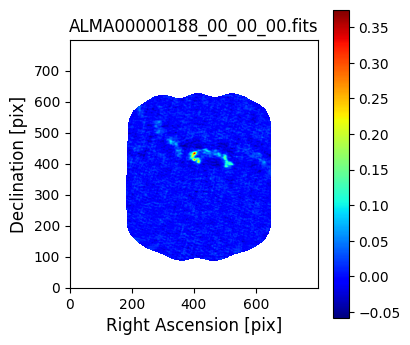

In [10]:
chan=28
ff,aa=plt.subplots(1,1, figsize=(4,4))
im=aa.imshow(fits.getdata(orgimfits)[0,chan,:,:], origin='lower', cmap='jet')
cbar=plt.colorbar(im, ax=aa)
aa.set_title(orgimfits)
aa.set_xlabel(imhd_A1['axisnames'][0]+" [pix]",size=12)
aa.set_ylabel(imhd_A1['axisnames'][1]+" [pix]",size=12)
plt.show()

試しに周波数方向の28チャンネル目のチャンネルイメージを表示しています。
表示するチャンネルは"chan"で変更可能です。

### サブイメージ作成

In [11]:
from casatasks import imsubimage
from casatasks import exportfits
imname = myimages
os.system('rm -rf '+imname)
imsubimage(imagename=orgimgdat, outfile=imname, dropdeg=True,
           region="centerbox[[413pix,357pix], [500pix,570pix]]")
exportfits(imagename=imname, fitsimage=imname+'.fits',
           dropstokes=True, overwrite=True)

余白部分を除くために、タスク<code><font color='red'>imsubimage</font></code>を使ってイメージデータの中央部分を切り出します。<br>
パラメータ<code>region</code>で、切り出す四角形の範囲の中心位置及び縦横方向の幅をpixelで指定しています（<code>region</code>による指定方法は後述）。

### ヘッダーから合成ビームサイズ（及び静止周波数）を確認

In [12]:
from casatasks import imhead
imname = myimages
imhd_A_res = imhead(imname)
bmaj  =imhead(imname, mode='get', hdkey='beammajor')['value']
bmajut=imhead(imname, mode='get', hdkey='beammajor')['unit']
bmin  =imhead(imname, mode='get', hdkey='beamminor')['value']
bminut=imhead(imname, mode='get', hdkey='beamminor')['unit']
bmpa  =imhead(imname, mode='get', hdkey='beampa')['value']
bmpaut=imhead(imname, mode='get', hdkey='beampa')['unit']
if bmpaut == 'rad':
    bmpav=bmpa*180/math.pi; bmpautv='deg'
else:
    bmpav=bmpa; bmpautv=bmpaut
print('Synthesized Beam:')
print(f'   Major Axis = {bmaj:.7f} {bmajut}')
print(f'   Minor Axis = {bmin:.7f} {bminut}')
print(f'   Pos. Angle = {bmpa:.7f} {bmpaut}')

imhd_B_res = imhead(imname, mode='get', hdkey='restfreq')
rfrq  =imhd_B_res['value']
rfrqut=imhd_B_res['unit']
if rfrqut == 'Hz':
    rfrqv=rfrq/10**9; rfrqutv='GHz'
else:
    rfrqv=rfrq; rfrqutv=rfrqut
print(f'Rest Frequency = {rfrqv:.9f} {rfrqutv}')

Synthesized Beam:
   Major Axis = 3.8690665 arcsec
   Minor Axis = 2.5323896 arcsec
   Pos. Angle = -89.5059891 deg
Rest Frequency = 115.271201800 GHz


タスク<code><font color='red'>imhead</font></code>で、イメージデータのヘッダーから合成ビームサイズ及び静止周波数の情報を読み取ります。

In [13]:
rfmod=0 # 0: expected frequency, other: unexpected frequency & defined
if rfmod != 0:
    rfrq=115271201800.0 # Hz
    rfrqv=rfrq/10**9; rfrqutv='GHz'
    print(f'Modified Rest Frequency = {rfrqv:.9f} {rfrqutv}')

ヘッダーから読み出した静止周波数が想定した輝線の周波数でない場合、"rfmod=1"として"rfrq"に周波数（単位：Hz）を指定して下さい。後でこのパラメータを使用します。

### イメージRMSを確認

In [14]:
from casatasks import imhead
from casatasks import imstat
imname = myimages
imhd_A_res = imhead(imname)
xspwd = 200 ; yspwd = 250 # pixels
cetpx = [str(int((imhd_A_res['shape'][0]-1)/2)), str(int((imhd_A_res['shape'][1]-1)/2))]
ofpx = 0 ; wdpx = 5
nchan = imhd_A_res['shape'][2]
stats1=imstat(imagename=imname,
      region='centerbox[['+cetpx[0]+'pix,'+cetpx[1]+'pix],['+str(xspwd)+'pix,'+str(yspwd)+'pix]],\
      range=['+str(ofpx)+'pix,'+str(ofpx+wdpx)+'pix]')
stats2=imstat(imagename=imname,
      region='centerbox[['+cetpx[0]+'pix,'+cetpx[1]+'pix],['+str(xspwd)+'pix,'+str(yspwd)+'pix]],\
      range=['+str(nchan-1-ofpx-wdpx)+'pix,'+str(nchan-1-ofpx)+'pix]')
stats3=imstat(imagename=imname,
      region='centerbox[['+cetpx[0]+'pix,'+cetpx[1]+'pix],['+str(xspwd)+'pix,'+str(yspwd)+'pix]],\
      range=['+str(ofpx+wdpx)+'pix,'+str(nchan-1-ofpx-wdpx)+'pix]')
imgrms=(stats1['rms'][0]+stats2['rms'][0])/2.0
imgpek=stats3['max'][0]
print(f'RMS of {imname}: {imgrms*1000:.9f} [mJy/beam]')
print(f'Peak of {imname}: {imgpek*1000:.9f} [mJy/beam]')

RMS of M100_combine_CO_cube.subim: 11.701785736 [mJy/beam]
Peak of M100_combine_CO_cube.subim: 673.587620258 [mJy/beam]


タスク<code><font color='red'>imstat</font></code>で、パラメータ<code>region</code>で指定された範囲内のイメージRMSやピーク値などの統計量を計算しています。<br>
領域<code>region</code>として、"<code>centerbox</code>"でイメージ中央を中心に "xspwd" ピクセル &times; "yspwd" ピクセル の四角形で囲まれる領域（上記では 200pix &times; 250pix）を、"<code>range</code>"で速度(周波数)方向の範囲をピクセル（上記では 0pix～5pix及び64pix～69pix）で指定します。
<br>
イメージRMS（ノイズの大きさ）を測るときは、天体からの放射のない（emission free）領域で測定する様にします。
例えば上記の様に、"<code>range</code>"で輝線の検出されていない周波数チャンネルを指定してRMSを求めます。
（上記スクリプトでは、"<code>range</code>"は両周波数端から"ofpx"ピクセルを除いて"wdpx"ピクセルの範囲をemission freeと想定して、両周波数端周辺で算出する様にしています。）
<br><br>
領域<code>region</code>の指定方法については、詳しくは以下をご覧ください。
<p style="padding-left:2em">
CASA Docs : <a href="https://casadocs.readthedocs.io/en/stable/notebooks/image_analysis.html#Region-File-Format" target="_blank" rel="noopener">Region File Format</a>
</p>

### 平均スペクトルを表示

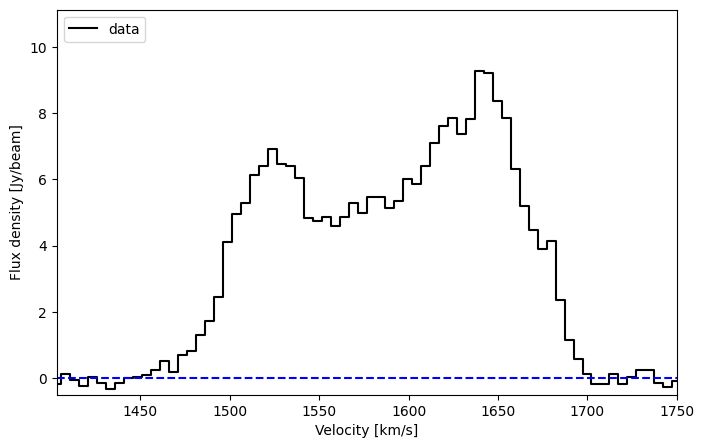

In [15]:
from casatasks import imhead
from casatasks import specflux
imname = myimages
splogf = imname+'.spec.log'
imhd_A_res = imhead(imname)
xspwd = 300 ; yspwd = 300 # pixels
cetpx = [str(int((imhd_A_res['shape'][0]-1)/2)), str(int((imhd_A_res['shape'][1]-1)/2))]
specflux(imagename=imname,
     region = 'centerbox[['+cetpx[0]+'pix,'+cetpx[1]+'pix],['+str(xspwd)+'pix,'+str(yspwd)+'pix]]',
     function='flux density', unit='km/s',
     logfile = splogf, overwrite=True)
dt1_ax,dt1_npx,dt1_frq,dt1_vl,dt1_fl = np.loadtxt(splogf, comments='#', unpack=True)

imgview=1 # yaxis selection: 0=channel, 1=velocity, 2=frequency
ymin = min(dt1_fl); ymax = max(dt1_fl)
ff, aa = plt.subplots(1,1, figsize=(8,5))
if imgview == 0:
    xmin = min(dt1_ax); xmax = max(dt1_ax)
    imr = aa.step(dt1_ax, dt1_fl, color="k", label="data", where="mid")
    aa.set_xlim(xmin, xmax)  ; aa.set_xlabel("Channel")
elif imgview == 1:
    xmin = min(dt1_vl); xmax = max(dt1_vl)
    imr = aa.step(dt1_vl, dt1_fl, color="k", label="data", where="mid")
    aa.set_xlim(xmin, xmax)  ; aa.set_xlabel("Velocity [km/s]")
elif imgview == 2:
    xmin = min(dt1_frq); xmax = max(dt1_frq)
    imr = aa.step(dt1_frq, dt1_fl, color="k", label="data", where="mid")
    aa.set_xlim(xmin, xmax)  ; aa.set_xlabel("Frequency [MHz]")
aa.set_ylim(ymin*1.5, ymax*1.2) ; aa.set_ylabel("Flux density [Jy/beam]")
plt.hlines([0], xmin, xmax, "blue", linestyles='dashed')
aa.legend(loc="upper left")
plt.savefig('m100_line_ave_spectrum.png', bbox_inches="tight", pad_inches=0.05)
plt.show()

イメージ中央を中心に "xspwd" ピクセル &times; "yspwd" ピクセル の四角形領域内の平均スペクトルです（上記では 300pix &times; 300pix）。タスク<code><font color='red'>specflux</font></code>で領域<code>region</code>の範囲内でスペクトルを作成します。表示されたスペクトルからダブルピークの輝線が検出されていることが分かります。<br>
横軸についてはスクリプト中の"imgview"を変更すると、チャンネル(imgview=0)・速度(imgview=1)・周波数(imgview=2)かを選択できます。
ラインのある範囲とない範囲、ラインの中心速度がどのあたりになるかに注意してください。

### モーメントマップ作成

In [16]:
from casatasks import immoments
from casatasks import exportfits
imname = myimages
imname_m0 = imname+'.m0'
imname_m1 = imname+'.m1'
imname_m2 = imname+'.m2'
imname_m8 = imname+'.m8'
imname_lt = [imname_m0, imname_m8, imname_m1, imname_m2]
cutrms = 5.0     # intensity cut off for moment1 & moment2
mochs = [8, 62]  # channel ranges for moment maps
os.system('rm -rf '+imname+'.m*')
# moment0 & moment8
immoments(imagename = imname, outfile = imname_m0, moments = 0,
       axis = 'spectral', chans=str(mochs[0])+'~'+str(mochs[1]))
immoments(imagename = imname, outfile = imname_m8, moments = 8,
       axis = 'spectral', chans=str(mochs[0])+'~'+str(mochs[1]))
# moment1 & moment2
immoments(imagename = imname, outfile = imname_m1, moments = 1,
       axis = 'spectral', chans=str(mochs[0])+'~'+str(mochs[1]),
       includepix=[imgrms*cutrms, 9999.])
immoments(imagename = imname, outfile = imname_m2, moments = 2,
       axis = 'spectral', chans=str(mochs[0])+'~'+str(mochs[1]),
       includepix=[imgrms*cutrms, 9999.])
# fits
for name in imname_lt:
    exportfits(imagename=name, fitsimage=name+'.fits',
               dropdeg=True, dropstokes=True, overwrite=True)

from casatasks import imhead
from casatasks import imstat
imhd_A_res = imhead(imname_m0)
xspwd = 400 ; yspwd = 400 # pixels
cetpx = [str(int(imhd_A_res['shape'][0]/2)), str(int(imhd_A_res['shape'][1]/2))]
stats3=imstat(imagename=imname_m0,
     region='centerbox[['+cetpx[0]+'pix,'+cetpx[1]+'pix],['+str(xspwd)+'pix,'+str(yspwd)+'pix]]')
imgpak=stats3['max'][0]
pakpos=stats3['maxpos'][0:2]
print(f'Peak of {imname_m0}: {imgpak:.9f} [Jy/beam]')
print('Peak position: '+stats3['maxposf'][0:27]+' @',pakpos,'pix')

Peak of M100_combine_CO_cube.subim.m0: 43.566867828 [Jy/beam]
Peak position: 12:22:54.935, +15.49.20.500 @ [236 339] pix


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'.


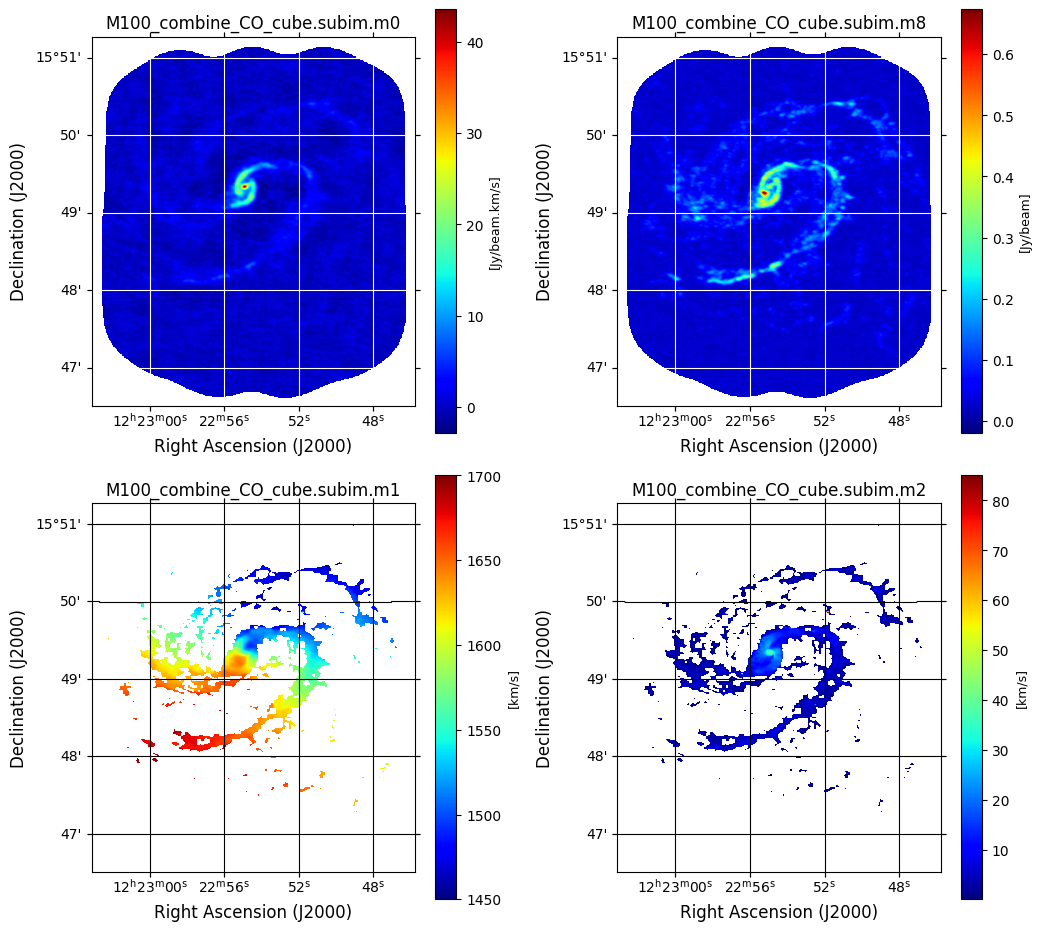

In [17]:
imname = myimages
imname_m0 = imname+'.m0'
imname_m1 = imname+'.m1'
imname_m2 = imname+'.m2'
imname_m8 = imname+'.m8'
imname_lt = [imname_m0, imname_m8, imname_m1, imname_m2]

ftdata_0 = fits.open(imname_m0+'.fits')
ft_dat_0 = ftdata_0[0].data
wmap_0 = WCS(ftdata_0[0].header)
unit_0 = "["+ftdata_0[0].header['BUNIT']+"]"
ftdata_0.close()

ftdata_8 = fits.open(imname_m8+'.fits')
ft_dat_8 = ftdata_8[0].data
wmap_8 = WCS(ftdata_8[0].header)
unit_8 = "["+ftdata_8[0].header['BUNIT']+"]"
ftdata_8.close()

ftdata_1 = fits.open(imname_m1+'.fits')
ft_dat_1 = ftdata_1[0].data
wmap_1 = WCS(ftdata_1[0].header)
unit_1 = "["+ftdata_1[0].header['BUNIT']+"]"
ftdata_1.close()

ftdata_2 = fits.open(imname_m2+'.fits')
ft_dat_2 = ftdata_2[0].data
wmap_2 = WCS(ftdata_2[0].header)
unit_2 = "["+ftdata_2[0].header['BUNIT']+"]"
ftdata_2.close()

fig = plt.figure(figsize=(12,10))
plt.subplots_adjust(top=1.0, wspace=0.3, hspace=0.1)

ax = plt.subplot(221, projection=wmap_0)
plt.imshow(ft_dat_0, origin='lower', cmap='jet')
cbar=plt.colorbar()
cbar.set_label(unit_0, size=9)
plt.title(imname_m0)
plt.grid(color='white', ls='solid')
plt.xlabel('Right Ascension (J2000)', size=12)
plt.ylabel('Declination (J2000)', size=12)

ax = plt.subplot(222, projection=wmap_8)
plt.imshow(ft_dat_8, origin='lower', cmap='jet')
cbar=plt.colorbar()
cbar.set_label(unit_8, size=9)
plt.title(imname_m8)
plt.grid(color='white', ls='solid')
plt.xlabel('Right Ascension (J2000)', size=12)
plt.ylabel('Declination (J2000)', size=12)

ax = plt.subplot(223, projection=wmap_1)
plt.imshow(ft_dat_1, origin='lower', cmap='jet')
cbar=plt.colorbar()
cbar.set_label(unit_1, size=9)
plt.title(imname_m1)
plt.grid(color='black', ls='solid')
plt.xlabel('Right Ascension (J2000)', size=12)
plt.ylabel('Declination (J2000)', size=12)

ax = plt.subplot(224, projection=wmap_2)
plt.imshow(ft_dat_2, origin='lower', cmap='jet')
cbar=plt.colorbar()
cbar.set_label(unit_2, size=9)
plt.title(imname_m2)
plt.grid(color='black', ls='solid')
plt.xlabel('Right Ascension (J2000)' ,size=12)
plt.ylabel('Declination (J2000)', size=12)

plt.savefig('m100_line_moment_maps_wcs.png', bbox_inches="tight", pad_inches=0.05)

スペクトル線データから作成されるイメージは2つの空間軸と1つの周波数(又は速度)軸からなる3次元のイメージキューブになり、タスク<code><font color='red'>immoments</font></code>によりこれらの3つのイメージ平面を操作してモーメントマップが作成できます。<br>
ここで作成したモーメントマップは、moment 0は積分強度マップ、moment 1は速度場マップ、moment 2は速度分散マップ、moment 8はピーク強度マップに相当します。
<br>
モーメントマップは、上記では"mochs"で指定した周波数チャンネル範囲で作成されます。また、モーメント1及びモーメント2マップについてはノイズの影響を避けるため、ある閾値 "cutrms" &#x3C3;（ここでは5&#x3C3;）以上のデータのみを使って作成しています（イメージRMSは先に測定した値を引用）。
<br>
その他、モーメント0マップのピーク強度・位置をタスク<code><font color='red'>imstat</font></code>で算出しています（ピーク位置は後でPVマップの基準位置として使用）。
<br><br>
モーメントマップについては、詳しくは以下を参考にして下さい。
- CASA Docs :
<a href="https://casadocs.readthedocs.io/en/stable/notebooks/image_analysis.html#Spectral-Analysis" target="_blank" rel="noopener">Spectral Analysis</a> - Computing the Moments of an Image Cube
- CASA Toolkit Reference Manual :
<a href="https://casa.nrao.edu/docs/CasaRef/image.moments.html" target="_blank" rel="noopener">image.moments - Function</a>

ここで作成された画像は、上記最終行"<code>plt.savefig('')</code>"で指定された画像ファイルにも出力されています（ここでは<code>m100_line_moment_maps_wcs.png</code>というPNGファイル）。
他の処理でも同様にPythonのmatplotlibモジュールを使って画像を作成している場合、一部の画像についてはPNGファイルにも出力されるようにしています。
また、拡張子を変更する事でpngの他に、jpg, pdf, eps など、他の形式でプロットを保存することもできます。

### プロファイルマップ作成

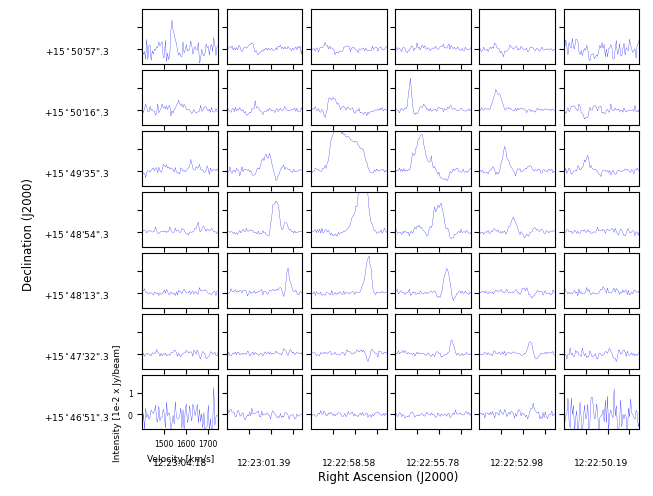

In [18]:
from casatasks import plotprofilemap
imname = myimages
plotprofilemap(imagename=imname, numpanels='6,7', spectralaxis='velocity',
               showtick=True, showticklabel=True, showaxislabel=True,
               figfile=imname+'.profilemap.png', overwrite=True)

タスク<code><font color='red'>plotprofilemap</font></code>により、プロファイルマップ（イメージ領域を格子状に分割し、それぞれの位置での平均スペクトルを表示）を作成しています。
パラメータ<code>numpanels</code>で縦横方向に何分割するか指定できます。また、パラメータ<code>figfile</code>で指定された名前のPNGファイルにも出力されます。

### PVマップ(位置速度図)作成

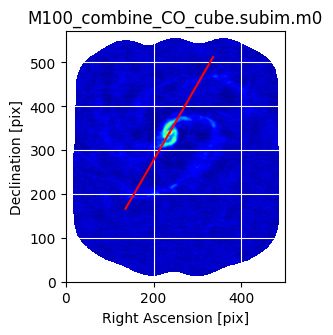

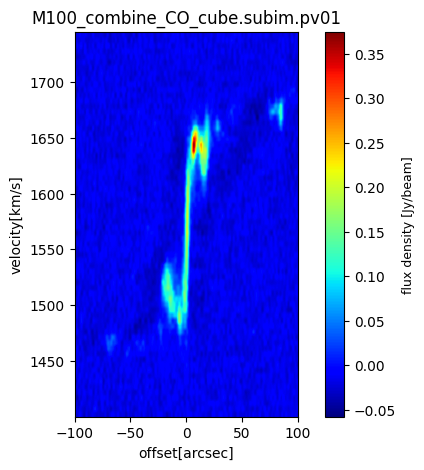

In [19]:
from casatasks import impv
from casatasks import exportfits
imname = myimages
pvname1 = myimages+'.pv01'
ctx=pakpos[0] ; cty=pakpos[1] # peak pixel of moment 0
pvpa  =  -30  # PA (deg)
pleng =  200  # arcsec
vlrag = '0~69' # vel.ch.range [ch]
os.system('rm -rf '+pvname1+'*')
impv(imagename = imname, outfile = pvname1,
     mode = 'length', center = [ctx, cty],
     length = str(pleng)+'arcsec', pa = str(pvpa)+'deg',
     width = 7, chans = vlrag)
exportfits(imagename=pvname1, fitsimage=pvname1+'.fits',
           velocity=True, dropstokes=True, overwrite=True)

## show slice line for PV map
imname_m0 = imname+'.m0'
ftdata_0 = fits.open(imname_m0+'.fits')
ft_dat_0 = ftdata_0[0].data
ft_hdr_0 = ftdata_0[0].header
ftdata_0.close()

cdelt1=abs(ft_hdr_0['CDELT1']*3600) ; cdelt2=abs(ft_hdr_0['CDELT2']*3600)
ofx_st=ctx-(pleng/cdelt1/2.)*math.cos((pvpa+90.)*math.pi/180.)
ofx_ed=ctx+(pleng/cdelt1/2.)*math.cos((pvpa+90.)*math.pi/180.)
ofy_st=cty-(pleng/cdelt2/2.)*math.sin((pvpa+90.)*math.pi/180.)
ofy_ed=cty+(pleng/cdelt2/2.)*math.sin((pvpa+90.)*math.pi/180.)

ff, aa = plt.subplots(1,1, figsize=(3.25,3.25))
imr = aa.imshow(ft_dat_0, origin='lower', cmap='jet')
aa.set_title(imname_m0)
aa.grid(color='white', ls='solid')
aa.set_xlabel('Right Ascension [pix]', size=10)
aa.set_ylabel('Declination [pix]', size=10)
aa.plot([ofx_st,ofx_ed], [ofy_st,ofy_ed], 'red')
plt.show()

## show PV map image
ftdat = fits.open(pvname1+'.fits')
ft_hdr = ftdat[0].header
ftdat.close()
ofs_st=(ft_hdr['CRVAL1']+(              1 -ft_hdr['CRPIX1'])*ft_hdr['CDELT1'])
ofs_ed=(ft_hdr['CRVAL1']+(ft_hdr['NAXIS1']-ft_hdr['CRPIX1'])*ft_hdr['CDELT1'])
vel_st=(ft_hdr['CRVAL2']+(              1 -ft_hdr['CRPIX2'])*ft_hdr['CDELT2'])/1000
vel_ed=(ft_hdr['CRVAL2']+(ft_hdr['NAXIS2']-ft_hdr['CRPIX2'])*ft_hdr['CDELT2'])/1000

ff, aa = plt.subplots(1,1, figsize=(7,5))
imr = aa.imshow(fits.getdata(pvname1+'.fits'),
                extent=(ofs_st,ofs_ed,vel_st,vel_ed), origin='lower', cmap='jet')
aa.set_xlabel("offset[arcsec]") ; aa.set_xlim(ofs_st,ofs_ed)
aa.set_ylabel("velocity[km/s]") ; aa.set_ylim(vel_st,vel_ed)
aa.set_aspect(1.0)
cbar=plt.colorbar(im, ax=aa)
cbar.set_label("flux density ["+ft_hdr['BUNIT']+"]",size=9)
aa.set_title(pvname1)
plt.savefig('m100_line_pv_maps.png', bbox_inches="tight", pad_inches=0.05)
plt.show()

イメージキューブデータは、前述の様に空間方向XYの2成分と周波数(速度)成分の3次元の情報を含みます。通常イメージデータを表示する場合は空間方向2成分になりますが、任意の空間方向と周波数(速度)方向の強度分布を位置速度図（PVマップ; Position-Velocity map）と言います。<br>
モーメント0マップでのピーク位置（前述）を基準に、指定した角度方向"pvpa"に長さ"pleng"の範囲でスライスしたPVマップをタスク<code><font color='red'>impv</font></code>で作成しています。
タスク<code><font color='red'>impv</font></code>のパラメータ"<code>width</code>"で、スライスする方向と垂直方向に平均する幅をピクセルで指定しています。<br>
下のイメージが作成されたPVマップで、横軸が位置(オフセット)、縦軸が速度になります。最初のイメージではモーメント0マップ上に、PVマップを作成するためにカットした直線の位置を赤線で表しています。

### 総分子ガス質量の算出

Total flux = 1358.9713282 Jy km/s


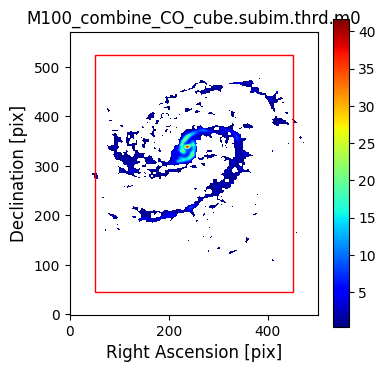

center freq = 114.6656090 GHz
redshift    = 0.0052814
CO luminosity = 7.6392645e+08 K kms-1 pc2
Total molecular gass mass = 3.3230801e+09 Mo


In [20]:
from casatasks import immath
from casatasks import exportfits
imname = myimages
imname2 = imname+'.thrd'
nsigma = 5.0               # <nsigma> threshold
threshold = imgrms*nsigma
os.system('rm -rf '+imname2)
immath(imagename=[imname], outfile=imname2,
       expr='IM0[IM0>%f]'%threshold)
imhd2_res = imhead(imname2)

from casatasks import imhead
imname2_m0 = imname2+'.m0'
#mochs = [8, 62]  # channel ranges for moment maps
os.system('rm -rf '+imname2_m0+'*')
immoments(imagename = imname2, outfile = imname2_m0, moments = 0,
       axis = 'spectral', chans=str(mochs[0])+'~'+str(mochs[1]))
exportfits(imagename=imname2_m0, fitsimage=imname2_m0+'.fits',
           dropstokes=True, overwrite=True)
imhd2_m0 = imhead(imname2_m0)

from casatasks import imstat
xspwd = 400 ; yspwd = 480 # pixels
cetpx = [str(int((imhd2_res['shape'][0]-1)/2)), str(int((imhd2_res['shape'][1]-1)/2))]
ofpx = 0 ; wdpx = 5
nchan = imhd2_res['shape'][2]
stats=imstat(imagename=imname2,
      region='centerbox[['+cetpx[0]+'pix,'+cetpx[1]+'pix],['+str(xspwd)+'pix,'+str(yspwd)+'pix]],\
      range=['+str(ofpx+wdpx)+'pix,'+str(nchan-1-ofpx-wdpx)+'pix]')
imgflx=stats['flux'][0]
print(f'Total flux = {imgflx:.7f} Jy km/s')

import matplotlib.patches as patches
ff,aa=plt.subplots(1,1, figsize=(4,4))
im=aa.imshow(fits.getdata(imname2_m0+'.fits')[0,:,:], origin='lower', cmap='jet')
cbar=plt.colorbar(im, ax=aa)
aa.set_title(imname2_m0)
aa.set_xlabel(imhd2_m0['axisnames'][0]+" [pix]",size=12)
aa.set_ylabel(imhd2_m0['axisnames'][1]+" [pix]",size=12)
blc=[int(cetpx[0])-xspwd/2, int(cetpx[1])-yspwd/2]
r = patches.Rectangle(xy=(blc[0], blc[1]), width=xspwd, height=yspwd, ec='r', fill=False)
aa.add_patch(r)
plt.savefig('m100_m0_threshold.png', bbox_inches="tight", pad_inches=0.05)
plt.show()

cent_freq=(imhd2_res['refval'][2]+((imhd2_res['shape'][2]/2)-imhd2_res['refpix'][2])*imhd2_res['incr'][2])
sysfreq=cent_freq
zzz = rfrq/sysfreq-1
sysfreq=sysfreq*10**(-9)
spunit='GHz' if imhd2_res['axisunits'][2]=='Hz' else 'no match'
print(f'center freq = {sysfreq:.7f} {spunit}')
print(f'redshift    = {zzz:.7f}')

ddd=15.2   # [Mpc] : luminosity distance for M100 (Sun et al.2018)
alpha=4.35 # [Mo pc-2 (K km/s)-1] (Sun et al.2018)
luminosity=(3.25*10**7)*imgflx*sysfreq**(-2)*ddd**2*(1+zzz)**(-3) # (Solomon & Vanden Bout 2005)
print(f'CO luminosity = {luminosity:.7e} K kms-1 pc2')
mmass=alpha*luminosity
print(f'Total molecular gass mass = {mmass:.7e} Mo')

CO分子輝線強度から銀河の総分子ガス質量を推定することが出来ます。
<br>
まず、キューブイメージから閾値 "nsigma" &#x3C3;（上記では5&#x3C3;）以下のピクセルを除外し、指定した範囲内のピクセル強度の合計からトータルフラックスを算出します。
上図は閾値以下を除外したキューブから作成した積分強度図（モーメント0マップ）で、赤い四角形で囲った範囲でトータルフラックスを求めています。
<br>
CO光度（luminosity）を求めるにあたり、バンド中心の周波数及びCO <i>J</i>=1-0輝線の静止周波数（前述）から赤方偏移（redshift）も計算しています。
<br>
分子ガス$\rm H_2$質量$M{\rm (H_2)}$は、CO分子輝線積分強度（total CO flux）$S_{\rm CO}\Delta{v}$より、以下の式で示されるとして計算しています。
$$L'_{\rm CO} = 3.25 \times10^7\;S_{\rm CO}\Delta{v}\;\nu_{\rm obs}^{-2}\;D_{\rm L}^2\;(1+z)^{-3}$$
$$M{\rm (H_2)} = \alpha_{\rm CO}\;L'_{\rm CO}$$
なお、それぞれの単位は
<small>
$L'_{\rm CO}\:[{\rm K\;km\,s^{−1}\;pc^2}]$ (total CO luminosity),
$S_{\rm CO}\Delta{v}\:[{\rm Jy\;km\,s^{-1}}]$ (integrated intensity),
$\nu_{\rm obs}\:[{\rm GHz}]$ (observing frequency),
$D_{\rm L}\:[{\rm Mpc}]$ (luminosity distance),
$M{\rm (H_2)}\:[{\rm M_{\odot}}]$ (H<sub>2</sub> molecular mass)
</small>
になります。<br>
<div align=right>(Solomon & Vanden Bout 2005)</div>
また、変換係数（CO-to-H<sub>2</sub> conversion factor）$\alpha_{\rm CO}$は
$$\alpha_{\rm CO(1-0)} = 4.35 \:{\rm M_{\odot}\;pc^{-2}\,(K\,km\,s^{-1})^{-1}}$$
<div align=right>(Sun et al.2018)</div>
を採用しています。

### チャネルマップ作成

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kapteyn: filename=kapteyn-3.4-cp310-cp310-linux_x86_64.whl size=2438529 sha256=7d89f49e504106b15b1dfd79221f0a7616907cc1a708fdf9123f3781bec74a2c
  Stored in directory: /root/.cache/pip/wheels/14/10/a5/92fe6dad813c5858ee4c9a3d2961e441f1d985c113bd9f4cae
Successfully built kapteyn
Vmin, Vmax of data in cube: -0.07489366 0.6735876
Min, max in this channel 12:  (-0.050170366, 0.09778434)
Min, max in this channel 14:  (-0.07489366, 0.2038951)
Min, max in this channel 16:  (-0.061335452, 0.2014264)
Min, max in this channel 18:  (-0.0570677, 0.37257904)
Min, max in this channel 20:  (-0.051610313, 0.33450663)
Min, max in this channel 22:  (-0.05875839, 0.3110198)
Min, max in this channel 24:  (-0.05571414, 0.32106727)
Min, max in this channel 26:  (-0.06826042, 0.32525235)
Min, max in this channel 28:  (-0.05666622, 0.36784855)
Min, max in this channel 30:  

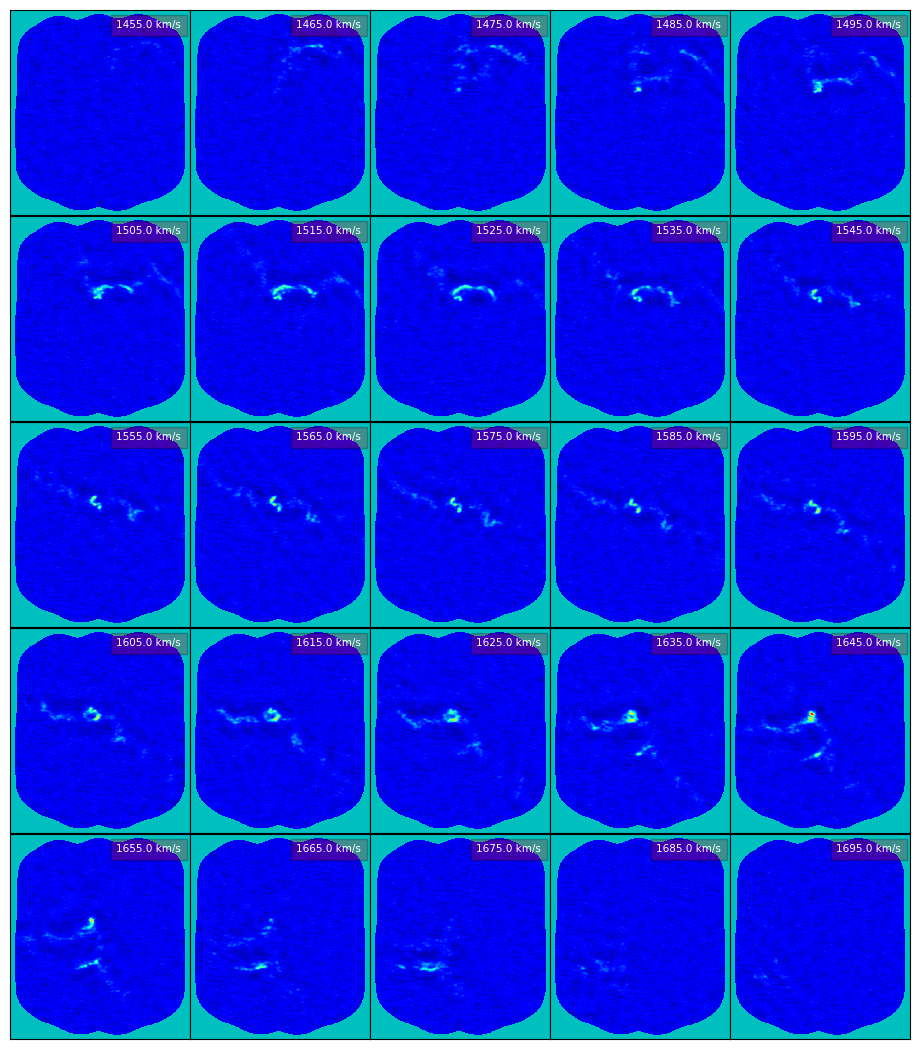

In [21]:
# Kapteyn Package
# https://www.astro.rug.nl/software/kapteyn/maputilstutorial.html#mosaics-of-plots
# https://www.astro.rug.nl/software/kapteyn/EXAMPLES/mu_channelmosaic.py

# preparation for Kapteyn Package
if ENV_COLAB:
    !pip install https://www.astro.rug.nl/software/kapteyn/kapteyn-3.4.tar.gz

import pkgutil
if pkgutil.find_loader("kapteyn"):
  from kapteyn import maputils # Kapteyn Packageがインストール済の場合に読み込む(import)

# function of making channel map
def channel_map(imname, start, end, step):
    # This is our function to convert velocity from m/s to km/s
    def fx(x):
        return x/1000.0

    # Create an object from the FITSimage class:
    fitsobj = maputils.FITSimage(imname+'.fits')
    specaxnum = fitsobj.proj.specaxnum
    lonaxnum = fitsobj.proj.lonaxnum
    lataxnum = fitsobj.proj.lataxnum
    spec = fitsobj.proj.sub(specaxnum).spectra("VRAD-???")

    #start = 0; end = fitsobj.proj.naxis[specaxnum-1]; step = 5
    channels = list(range(start,end,step))
    nchannels = len(channels)

    fig = plt.figure(figsize=(9,10.3))
    fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

    vmin, vmax = fitsobj.get_dataminmax()
    print("Vmin, Vmax of data in cube:", vmin, vmax)
    cmap = 'jet'             # Colormap
    cols = 5
    rows = nchannels // cols

    if rows*cols < nchannels:
        rows += 1

    for i, ch in enumerate(channels):
        fitsobj.set_imageaxes(lonaxnum, lataxnum, slicepos=ch)
        print("Min, max in this channel "+str(ch)+": ", fitsobj.get_dataminmax(box=True))
        frame = fig.add_subplot(rows, cols, i+1)
        mplim = fitsobj.Annotatedimage(frame,
                                       clipmin=vmin, clipmax=vmax,
                                       cmap=cmap)
        mplim.Image()

        vel = spec.toworld1d(ch)
#        velinfo = "ch%d = %.1f km/s" % (ch, vel/1000.0)
        velinfo = "%.1f km/s" % (vel/1000.0)
        frame.text(0.95, 0.95, velinfo,
                   horizontalalignment='right',
                   verticalalignment='top',
                   transform = frame.transAxes,
                   fontsize=7.5, color='w',
                   bbox=dict(facecolor='red', alpha=0.25))
        mplim.plot()
        if i == 0:
            cmap = mplim.cmap
        mplim.interact_imagecolors()

    plt.savefig(imname+'.chmaps.png', bbox_inches="tight", pad_inches=0.05)
    plt.show()

myimages2='M100_combine_CO_cube.subim'
# making channel map
moduleList = sys.modules
if 'kapteyn.mplutil' in moduleList: # kapteyn.mplutilがimportされ利用可能な場合
    start = 12; end = 62; step = 2 # velocity range (pix) for channel map
    channel_map(myimages2, start, end, step)
else:
    print("Channel map is not made because Kapteyn Package is not available.")

チャンネルマップとは、一定の視線速度の範囲（チャンネル）ごとの輝線スペクトルの平均強度の分布図で、天体の速度構造を把握するのに有用です。<br>
CASAには現状チャンネルマップを直接きれいに作るタスクがないので、pythonで実現するために別途モジュールなどが必要になります。
ここでは参考までに<a href="https://www.astro.rug.nl/software/kapteyn/" target="_blank" rel="noopener">Kapteyn Package</a>を使用してチャンネルマップを作成しています。
Kapteyn Packageでのチャンネルマップについては、"Tutorials"の"<a href="https://www.astro.rug.nl/software/kapteyn/maputilstutorial.html#mosaics-of-plots" target="_blank" rel="noopener">Mosaics of plots</a>"を参考にして下さい（<a href="https://www.astro.rug.nl/software/kapteyn/EXAMPLES/mu_channelmosaic.py" target="_blank" rel="noopener">サンプルスクリプト</a>）。Kapteyn Packageには他にも様々な機能があります。
<br>
上記スクリプトでは、最初にKapteyn Packageをインストール（Google Cobab環境の場合）、チャンネルマップ作成処理を"channel_map"という関数で定義し、イメージキューブFITSデータから指定した速度範囲でチャンネルマップを作成します。
速度範囲については、ピクセル単位で"start"以上・"end"未満の範囲で"step"の間隔で抽出して、チャンネルマップとして表示します。
上記の場合は、12 ch &le; n &lt; 62 chの範囲で2 チャンネル間隔（つまり 12, 14, 16, 18, ..., 58, 60 ch）で合計25枚のチャンネルイメージを表示しています。
<br><br>
欠損なしに表示したい場合（1 チャンネル間隔）は、あらかじめキューブデータを速度方向に平滑化する必要があります。
下記では、タスク<code><font color='red'>imrebin</font></code>を使って、3軸目の速度(周波数)方向を2チャンネル毎に平均化し、その結果のキューブイメージをチャンネルマップとして表示しています。
上記のチャネルマップと同じ速度範囲を1 チャンネル間隔で25枚のチャンネルイメージとして表示されています。

[501 571  70]  : pix num in M100_combine_CO_cube.subim
[501 571  35]  : pix num in M100_combine_CO_cube.subim.bin
Vmin, Vmax of data in cube: -0.05760912 0.63767827
Min, max in this channel 6:  (-0.035271764, 0.06455249)
Min, max in this channel 7:  (-0.048790798, 0.16031416)
Min, max in this channel 8:  (-0.049761303, 0.21843538)
Min, max in this channel 9:  (-0.047287956, 0.31710508)
Min, max in this channel 10:  (-0.044970207, 0.34145635)
Min, max in this channel 11:  (-0.048347432, 0.30401915)
Min, max in this channel 12:  (-0.053054597, 0.3290513)
Min, max in this channel 13:  (-0.053542882, 0.31601554)
Min, max in this channel 14:  (-0.05148925, 0.3864457)
Min, max in this channel 15:  (-0.04893706, 0.36954725)
Min, max in this channel 16:  (-0.05760912, 0.34645462)
Min, max in this channel 17:  (-0.049499482, 0.3919472)
Min, max in this channel 18:  (-0.048610717, 0.43377686)
Min, max in this channel 19:  (-0.043291587, 0.3854701)
Min, max in this channel 20:  (-0.048655145, 0.4

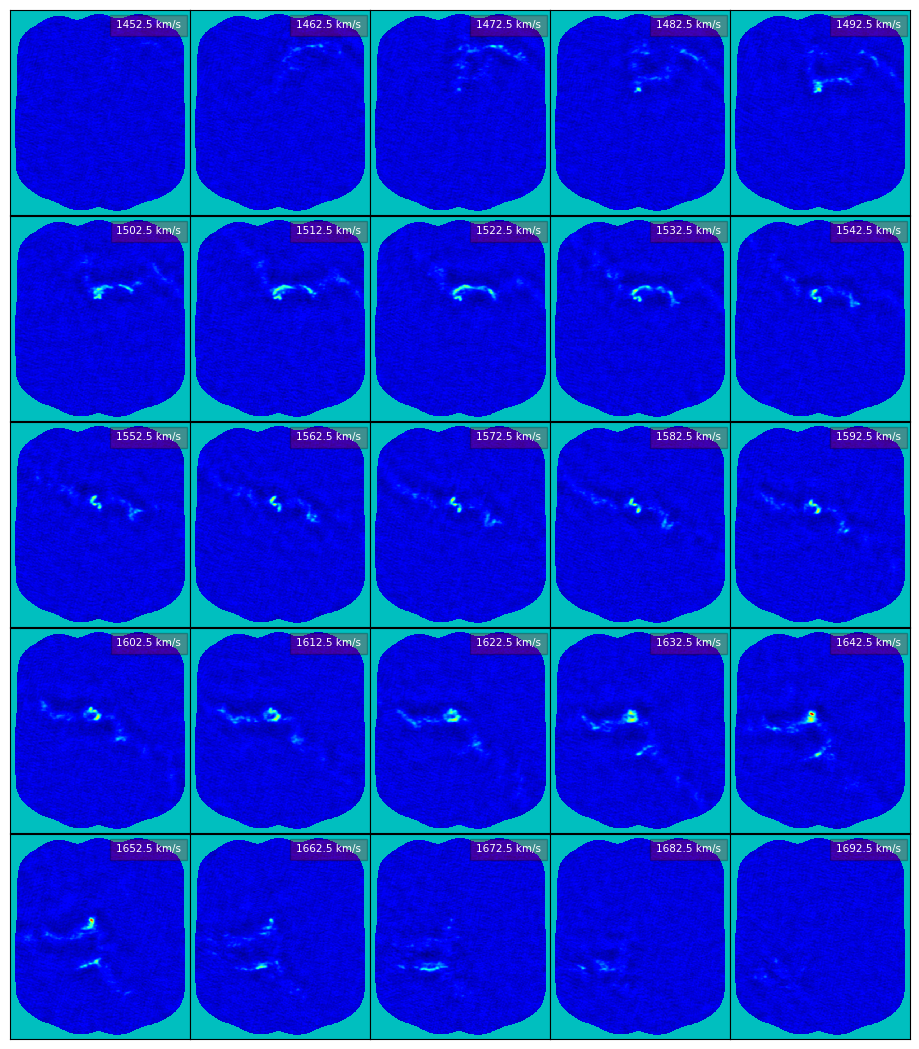

In [22]:
from casatasks import imhead
from casatasks import imrebin
from casatasks import exportfits
myimages2='M100_combine_CO_cube.subim'
myimages3='M100_combine_CO_cube.subim.bin'
os.system('rm -rf '+myimages3)
imrebin(imagename=myimages2, outfile=myimages3, factor=[1,1,2])
imname = myimages2
imhd_C1 = imhead(imname); print(imhd_C1['shape'], ' : pix num in '+imname)
imname = myimages3
imhd_C2 = imhead(imname); print(imhd_C2['shape'], ' : pix num in '+imname)
exportfits(imagename=imname, fitsimage=imname+'.fits',
           dropstokes=True, overwrite=True)

# making channel map
moduleList = sys.modules
if 'kapteyn.mplutil' in moduleList:
    start = 6; end = 31; step = 1 # velocity range (pix) for channel map
    channel_map(myimages3, start, end, step)
else:
    print("Channel map is not made because Kapteyn Package is not available.")

In [23]:
print("END")

END
